In [ ]:
# default_exp core2

# Resnet18 : pretraining with classification

> We pretrain a resnet18 for a few epochs on a classification task and then use these weights for the class separation task

In [ ]:
#hide
%config autocompleter.use_jedi=False
from nbdev.showdoc import *
from fastai.vision import *
import random

In [ ]:
PATH = untar_data(URLs.IMAGEWOOF_320)
PATH.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/val'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train')]

# Usual Model

In [ ]:
data = ImageDataBunch.from_folder(PATH, train='train', valid='val',
                                 ds_tfms=get_transforms(), size=224)

# data.show_batch()

len(data.train_ds)

12454

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], pretrained=False)
gc.collect()

19

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.721011,2.195215,0.228000,00:34
1,2.210053,2.064950,0.288000,00:34
2,1.910352,2.265770,0.238000,00:33
3,1.598470,1.412858,0.494000,00:33
4,1.401897,1.333884,0.532000,00:34


In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.410986,1.509277,0.488000,00:34
1,1.398198,1.488784,0.504000,00:33
2,1.299351,1.330117,0.566000,00:33
3,1.169201,1.163877,0.582000,00:34
4,1.107713,1.072188,0.640000,00:33


In [ ]:
learn2 = learn

In [ ]:
def get_model(pretrained=True, learn=learn2):
    return learn.model

# Continuing

In [ ]:
TRAIN = PATH/'train'

In [ ]:
TRAIN.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02093754'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02088364'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02089973'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02087394'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02111889'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02099601'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02105641'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02086240'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02115641'),
 PosixPath('/home/ubuntu/.fastai/data/imagewoof-320/train/n02096294')]

# Make CSV

In [ ]:
def get_label_from_names(names:Path):
    labels = []
    if is_listy(names):
        for name in names: 
            labels.append(Path(name).parent.name)
        return labels
    else: 
        return Path(names).parent.name
    
names = get_files(TRAIN, recurse=True, extensions='.JPEG')
get_label_from_names(names[:10])

['n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754',
 'n02093754']

In [ ]:
def make_df(names:list):
    names2 = names.copy()
    random.shuffle(names2)
    df = pd.DataFrame(data=[names, names2]).T
    labels1 = np.array(get_label_from_names(list(df.iloc[:,0])))
    labels2 = np.array(get_label_from_names(list(df.iloc[:,1])))
    labels = (labels1 == labels2).astype(np.int32)
    df['label'] = labels
    df.columns = ['image1', 'image2', 'label']
    return df

df = make_df(get_files(TRAIN, recurse=True, extensions='.JPEG'))
df.head()

,image1,image2,label
0,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,1
1,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
2,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
3,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
4,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2777371090>]], dtype=object)

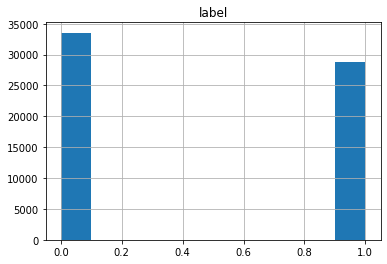

In [ ]:
def make_csv_from_path(TRAIN=TRAIN, mult=5):
    TRAIN = Path(TRAIN)
    names60 = []
    dfs = []
    for d in TRAIN.ls():
        names = d.ls() * mult
        random.shuffle(names)
        names40 = names[:int(len(names)*0.4)]
        names60.extend(names[int(len(names)*0.4):])
        dfs.append(make_df(names40))
        
    df60 = make_df(names60)
    for df in dfs:
        df60 = df60.append(df)

    return df60

df = make_csv_from_path(TRAIN)
df.hist()

# FastAI Databunch

In [ ]:
df.head()

,image1,image2,label
0,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,1
1,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
2,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
3,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0
4,/home/ubuntu/.fastai/data/imagewoof-320/train/...,/home/ubuntu/.fastai/data/imagewoof-320/train/...,0


In [ ]:
learn = None
data = None
gc.collect()

135

In [ ]:
size = 256
class DoubleImageList(ImageList):
    def open(self, fn):
        im1 = open_image(fn[0]).resize(size)
        im2 = open_image(fn[1]).resize(size)
        black_space = torch.zeros(3, size, 20)
        return Image(torch.cat([im1.data, black_space, im2.data], dim = 2))

In [ ]:
data = (DoubleImageList.from_df(df, path='/', cols=['image1', 'image2'])
        .split_by_rand_pct(0.2)
        .label_from_df(cols=['label'])
        .transform(get_transforms())
        .databunch(bs=128)
        .normalize(imagenet_stats))

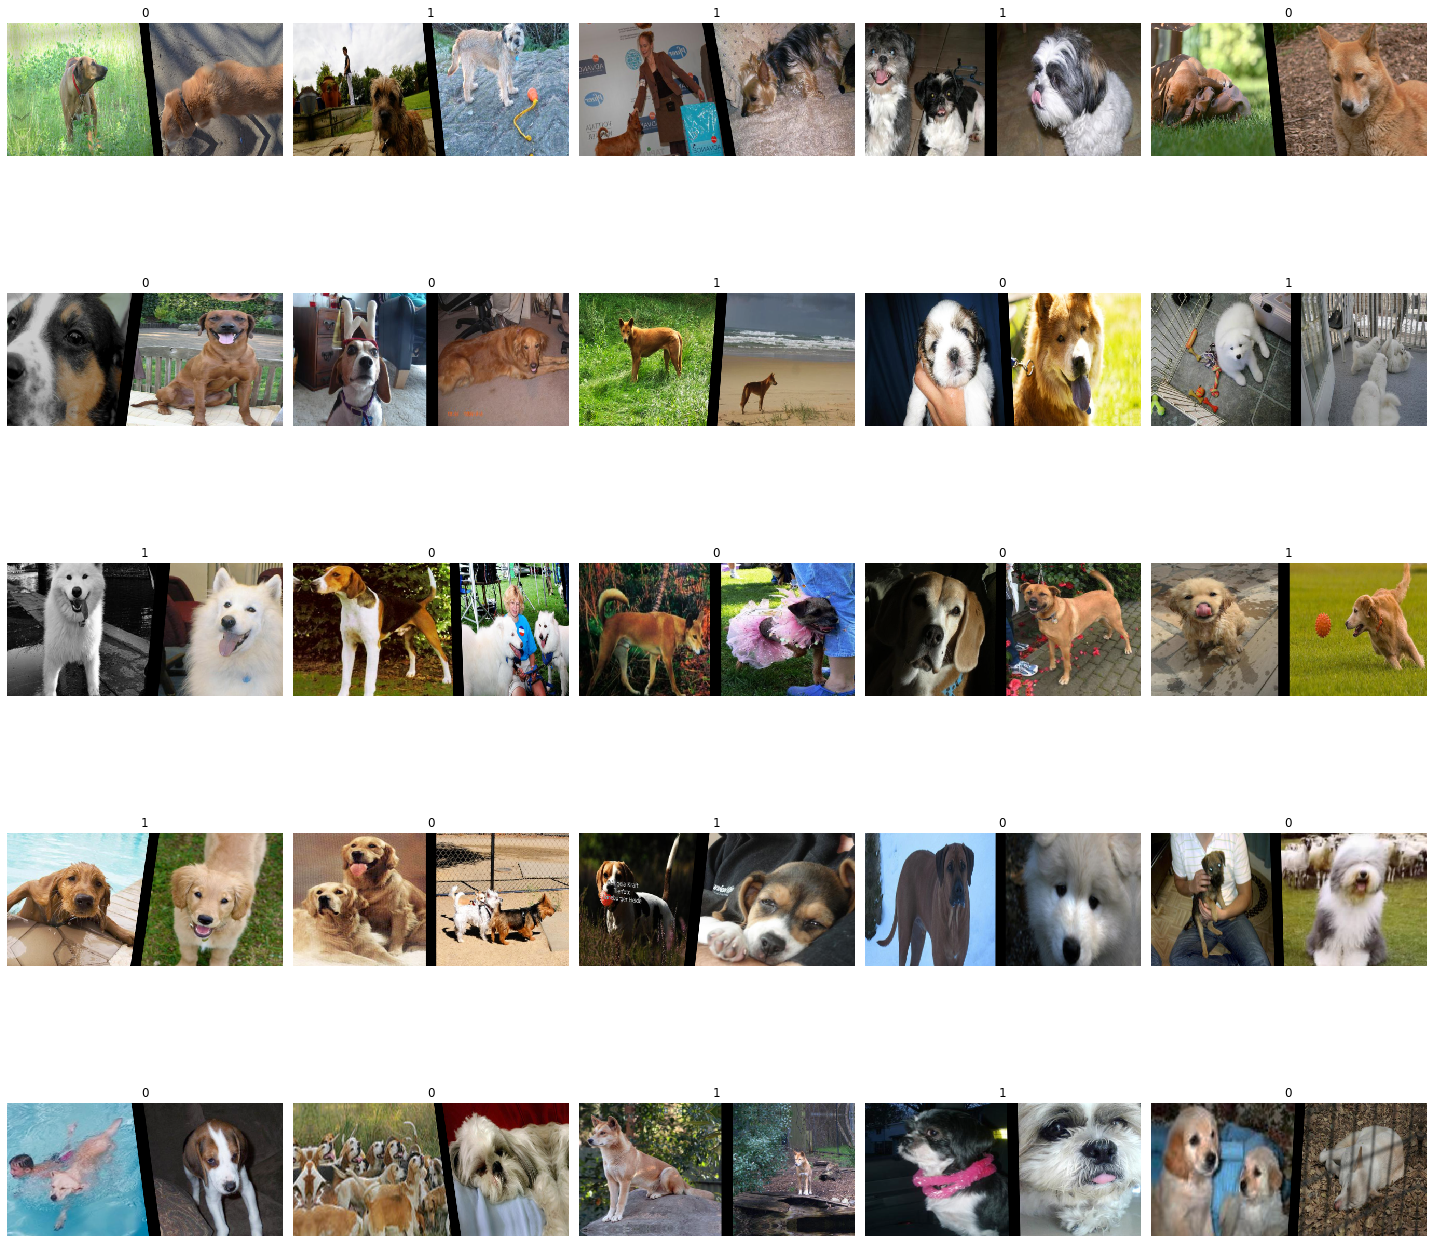

In [ ]:
data.show_batch()

# Model

In [ ]:
# m = models.xresnet50

# mom, alpha, eps = 0.9, 0.99, 1e-6
# opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

# learn = (Learner(data, m(c_out=10), wd=1e-2, opt_func=opt_func,
#         metrics=[accuracy],
#         bn_wd=False, true_wd=True,
#         loss_func = LabelSmoothingCrossEntropy())
#         )

In [ ]:
learn = cnn_learner(data, get_model, metrics=[accuracy], pretrained=False)
gc.collect()

52780

In [ ]:
learn2 = None
gc.collect()

20

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.687188,0.651726,0.611209,05:47
1,0.635782,0.624928,0.648306,05:46
2,0.552688,0.539966,0.726835,05:46


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.641280,0.676570,0.578850,05:47
1,0.591381,0.589784,0.683716,05:47
2,0.513946,0.506031,0.749077,05:48


# Testing

1. Take N images from each class as query images
2. For each image in validation set:
    1. Create sample with each support image
    2. Stack in one batch
    3. Get predictions
    4. Get mean probabilities
    5. ARGMAX

In [ ]:
TRAIN = TRAIN
VAL = PATH/'val'

In [ ]:
num_images = 15
classes = 10
query_images = OrderedDict()
random.seed(42)
for d in TRAIN.ls():
    cls = d.name
    images = d.ls()
    random.shuffle(images)
    images = images[:num_images]
    query_images[cls] = images

In [ ]:
samples = get_files(VAL, extensions='.JPEG', recurse=True)

In [ ]:
def create_sample_from_paths(path1, path2):
    im1 = open_image(path1).resize(320)
    im2 = open_image(path2).resize(320)
    black_space = torch.zeros(3, 320, 20)
    image = torch.cat([im1.data, black_space, im2.data], dim = 2)
    image = learn.data.norm((image, torch.zeros(1)))[0].unsqueeze(0).cuda()
    return image

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
total, accurate, accuracy = 0.0, 0.0, 0.0
predictions = []
pbar = tqdm(samples)
learn.model.eval()
for sample in pbar:
    label = get_label_from_names(sample)
    positive, negative = [], []
    for key, value in query_images.items():
        if key == label:
            for val in value:
                positive.append(create_sample_from_paths(sample, val))
        else:
            for val in value:
                negative.append(create_sample_from_paths(sample, val))
    positive.extend(negative)
    stack = torch.cat(positive, dim=0)
    predictions.append(learn.model(stack)[:,1].reshape(classes, num_images).detach().cpu())
    preds = predictions[-1].mean(1).argmax().item()
    if preds == 0:
        accurate += 1
    total += 1
    accuracy = accurate / total
    pbar.set_description(f"Accuracy : {accuracy}")
print(accurate/total)


0.396


In [ ]:
learn.path = Path.cwd()/'models'

In [ ]:
learn.save('first')